In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

# Add laggy features 

In [36]:
location = pd.read_csv('/kaggle/input/hse-dab-naf-23/LOCATION.csv', delimiter=';')
product = pd.read_csv('/kaggle/input/hse-dab-naf-23/PRODUCT.csv', delimiter=';')
vanila_data = pd.read_csv('/kaggle/input/hse-dab-naf-23/train.csv')
vanila_test = pd.read_csv('/kaggle/input/hse-dab-naf-23/test.csv')

KeyboardInterrupt: 

In [ ]:
for col in location.columns:
    if len(location[col].unique()) == 1:
        location = location.drop(columns = [col])

In [ ]:
for col in product.columns:
    if len(product[col].unique()) == 1:
        product = product.drop(columns = [col])

In [ ]:
# создаем "тупые" фичи

data = vanila_data[(~vanila_data.location_id.isna()) & (~vanila_data.product_id.isna())].copy()

data['sale'] = (data['PRICE_REGULAR'] - data['PRICE_AFTER_DISC'])
data['sale_part'] = (data['PRICE_REGULAR'] - data['PRICE_AFTER_DISC']) / data['PRICE_REGULAR']
data['period_dt'] = pd.to_datetime(data["period_dt"])
data['week_in_year'] = data["period_dt"].dt.isocalendar().week.astype(int)
data['year_num'] = data["period_dt"].dt.isocalendar().year.astype(int) - 2016
data['week_num'] = data['week_in_year'] + data['year_num']*52 - 50

data.sort_values(by=['week_num'], inplace=True)

In [ ]:

data['num_hist'] = -1

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(0).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 1
data.index = data.id

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(1).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 2
data.index = data.id

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(2).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 3
data.index = data.id

pos = pd.MultiIndex.from_frame(data.groupby(by=['location_id', 'product_id']).week_num.nth(3).reset_index())
data.index = pd.MultiIndex.from_frame(data[['location_id', 'product_id', 'week_num']])
data.loc[pos, 'num_hist'] = 4
data.index = data.id

In [ ]:
for i in range(8):
    num = 0.3 + 0.2 * i
    data[f'special_week_{num}'] = 0
    mean_demands = []
    weeks = []
    for week_num in sorted(data.week_num.unique()):
        mean_demands.append(data[data.week_num == week_num].demand.mean())
        weeks.append(week_num)
    weeks = np.array(weeks)
    mean_demands = np.array(mean_demands)
    data.loc[data.week_num.isin(weeks[mean_demands > num]), f'special_week_{num}'] = 1

In [ ]:
data.index = data.id

In [ ]:
# фиксируем индексы валидационной выборки

validation_weeks = [104, 105, 106, 107]
validation_ids = data[data.week_num.isin(validation_weeks) & (data.num_hist == 1)].id

# выкидываем на всякий случай прошлогоднюю неделю

# data = data[~data.week_num.isin(validation_weeks)]

In [ ]:
test = data.loc[test.index, :].drop(columns=['demand'])

In [ ]:
# добавляем параметры локации и продукта

data.index = data.location_id
location.index = location.STORE_LOCATION_RK
data = data.join(location.drop(columns=['STORE_LOCATION_RK']), rsuffix='_location')

data.index = data.product_id
product.index = product.PRODUCT_RK
data = data.join(product.drop(columns=['PRODUCT_RK']), rsuffix='_product')

data.index = data.id

In [ ]:
data = data[data.PRODUCT_LVL_RK5 == 3865]

In [ ]:
mean_at_loc_RK = data.groupby(by='STORE_LOCATION_LVL_RK3').demand.mean()
mean_at_prod_RK = data.groupby(by='PRODUCT_LVL_RK6').demand.mean()

data.index = data.STORE_LOCATION_LVL_RK3
data['mean_at_loc_RK'] = mean_at_loc_RK

data.index = data.PRODUCT_LVL_RK6
data['mean_at_prod_RK'] = mean_at_prod_RK


In [ ]:
# Средние значения ответа
group_all = data[['week_in_year', 'location_id', 'demand']].groupby(by=['week_in_year', 'location_id'], as_index=False).mean()

group_date = data[['week_in_year', 'demand']].groupby(by=['week_in_year'], as_index=False).mean()

data = data.merge(group_all, on=['week_in_year', 'location_id'], how='left', suffixes=('', '_all'))
# test_data = test_data.merge(group_all, on=['week_in_year', 'location_id'], how='left', suffixes=('', '_all'))
data = data.merge(group_date, on=['week_in_year'], how='left', suffixes=('', '_new'))
# test_data = test_data.merge(group_date, on=['week_in_year'], how='left', suffixes=('', '_new'))



In [ ]:
mean_at_loc_id = data.groupby(by='location_id').demand.mean()
mean_at_prod_id = data.groupby(by='product_id').demand.mean()

data.index = data.location_id
data['mean_at_loc_id'] = mean_at_loc_id

data.index = data.product_id
data['mean_at_prod_id'] = mean_at_prod_id


In [ ]:
data.index = data.id

In [ ]:
for col in data.columns:
    if len(data[col].unique()) == 1:
        data = data.drop(columns = [col])

In [ ]:
data.loc[data.PROMO1_FLAG.isna(), 'PROMO1_FLAG'] = 0
data.loc[data.PROMO2_FLAG.isna(), 'PROMO2_FLAG'] = 0

In [ ]:
from itertools import product

In [ ]:
data['One'] = 1

In [ ]:
data.columns

In [ ]:
important_columns = ['period_dt', 'STORE_LOCATION_LVL_RK3', 'location_id', 'product_id', 'demand', 'PROMO1_FLAG',
        'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 'special_week_0.9000000000000001', 
        'special_week_1.1', 'special_week_1.3', 'special_week_1.5000000000000002', 'PRODUCT_LVL_RK6']

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_week = x.groupby(pd.PeriodIndex(x[date_col], freq='W'))
    results = groupby_week.sum(min_count=1, numeric_only = float)
    
    idx = pd.period_range(min_date, max_date, freq='W')
    results = results.reindex(idx, fill_value=np.nan)
    
    results.index.rename(date_col, inplace=True)
    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col)[target_cols].agg(
        preagg_method).reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()
    
    data_preag_filled[date_col] = data_preag_filled[date_col].dt.start_time
    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1], group_keys=False).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['demand'],
        id_cols: list = ['location_id', 'product_id'],
        date_col: str = 'period_dt',
        lags: list = [4, 8, 12],
        windows: list = ['7D', '14D', '21D', '28D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['Week_Num', 'Promo'],
        ewm_params: dict = {'week': [1, 4], 'Promo': [14, 42]}) -> pd.DataFrame:
    
    ''' 
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    for filter_col, lag, preagg in tqdm(product(dynamic_filters, lags, preagg_methods), 
                                        total = len(dynamic_filters) * len(lags) * len(preagg_methods), 
                                        position = 0, desc="filter, lag and preagg", colour='green'):
        group_col = group_col = [filter_col] + id_cols + [date_col]
        data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)
                ## add ewm features
        for alpha in tqdm(ewm_params.get(filter_col, []), 
                          position = 1, desc="alpha", 
                          colour='red'):
            ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
            ewm = shift(ewm_filled, group_col, date_col, lag)
            new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                    format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}
                    
            out_df = pd.merge(out_df, ewm.rename(columns=new_names), on=group_col)

        for w, method in tqdm(product(windows, agg_methods), 
                              total=len(windows) * len(agg_methods),
                              position = 2, desc="window and method", 
                              colour='blue'):          
            rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

            ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
            rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

            method_name = method.__name__ if type(
                            method) != str else method

            new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}
                        
            out_df = pd.merge(out_df, rolling.rename(columns=new_names), on=group_col)

    return out_df

In [ ]:
target_cols = ['demand']
id_cols = ['location_id']
date_col = 'period_dt'

In [ ]:
%%time
data = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [4, 8, 12, 16, 52]
                    , windows = [1, 4, 8, 12, 16, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist', 'year_num']
                    , ewm_params={'One': [1, 2, 4, 8, 16, 32], 'PROMO1_FLAG' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_0.5' : [1, 2, 4, 8, 16, 32], 'special_week_0.7' : [1, 2, 4, 8, 16, 32],
                                  'special_week_0.9000000000000001' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_1.1' : [1, 2, 4, 8, 16, 32], 'num_hist' : [1, 2, 4, 8, 16, 32], 
                                  'year_num' : [1, 2, 4, 8, 16, 32], 'special_week_1.3' : [1, 2, 4, 8, 16, 32], 'special_week_0.3' : [1, 2, 4, 8, 16, 32]}
                    , agg_methods = ['mean', 'median', 'max']
                    )

In [ ]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.5000000000000002',
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
]+ [
    column for column in data if column.find('hashing') != -1
]

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]
data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
tmp_data = tmp_data[data.num_hist != -1]
train = tmp_data[(~tmp_data.demand.isna())].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    n_estimators=700, 
    random_seed=42)

classifier.fit(train, target)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [ ]:
len(data.columns)

In [ ]:
target_cols = ['demand']
id_cols = ['STORE_LOCATION_LVL_RK3']
date_col = 'period_dt'

In [ ]:
%%time
data = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [4, 8, 12, 16, 52]
                    , windows = [1, 4, 8, 12, 16, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist', 'year_num']
                    , ewm_params={'One': [1, 2, 8, 16, 32], 'PROMO1_FLAG' : [1, 2, 8, 16, 32], 
                                  'special_week_0.5' : [1, 2, 8, 16, 32], 'special_week_0.7' : [1, 2, 8, 16, 32],
                                  'special_week_0.9000000000000001' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_1.1' : [1, 2, 8, 16, 32], 'num_hist' : [1, 2, 8, 16, 32], 
                                  'year_num' : [1, 2, 8, 16, 32], 'special_week_1.3' : [1, 2, 8, 16, 32], 'special_week_0.3' : [1, 2, 8, 16, 32]}
                    , agg_methods = ['mean', 'median', 'max']
                    )

In [ ]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.5000000000000002',
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
] + [
    column for column in data if column.find('hashing') != -1
]

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]

categorical_columns = list(set(categorical_columns) & set(data.columns))
bad_features = list(set(bad_features) & set(data.columns))

data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
tmp_data = tmp_data[data.num_hist != -1]
train = tmp_data[(~tmp_data.demand.isna())].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    n_estimators=700, 
    random_seed=42)

classifier.fit(train, target)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [ ]:
len(data.columns)

In [37]:
target_cols = ['demand']
id_cols = ['PRODUCT_LVL_RK6']
date_col = 'period_dt'

In [38]:
%%time
data = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [4, 8, 12, 16, 52]
                    , windows = [1, 4, 8, 12, 16, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist']
                    , ewm_params={'One': [1, 2, 8, 16, 32], 'PROMO1_FLAG' : [1, 2, 8, 16, 32], 
                                  'special_week_0.5' : [1, 2, 8, 16, 32], 'special_week_0.7' : [1, 2, 8, 16, 32],
                                  'special_week_0.9000000000000001' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_1.1' : [1, 2, 8, 16, 32], 'num_hist' : [1, 2, 8, 16, 32], 
                                  'special_week_1.3' : [1, 2, 8, 16, 32], 'special_week_0.3' : [1, 2, 8, 16, 32]}
                    , agg_methods = ['mean', 'median', 'max']
                    )

alpha: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


window and method:   0%|          | 0/18 [00:00<?, ?it/s]

window and method:   6%|▌         | 1/18 [00:00<00:10,  1.62it/s]

window and method:  11%|█         | 2/18 [00:01<00:09,  1.61it/s]

window and method:  17%|█▋        | 3/18 [00:01<00:09,  1.61it/s]

window and method:  22%|██▏       | 4/18 [00:02<00:08,  1.61it/s]

window and method:  28%|██▊       | 5/18 [00:03<00:08,  1.60it/s]

window and method:  33%|███▎      | 6/18 [00:03<00:07,  1.60it/s]

window and method:  39%|███▉      | 7/18 [00:04<00:06,  1.59it/s]

window and method:  44%|████▍     | 8/18 [00:05<00:06,  1.58it/s]

window and method:  50%|█████     | 9/18 [00:05<00:05,  1.58it/s]

window and method:  56%|█████▌    | 10/18 [00:06<00:05,  1.57it/s]

window and method:  61%|██████    | 11/18 [00:06<00:04,  1.57it/s]

window and method:  67%|██████▋   | 12/18 [00:07<00:03,  1.58it/s]

window and method:  72%|███████▏  | 13/18 [00:08<00:03,  1.58it/s]

window and 

CPU times: user 27min 59s, sys: 3.59 s, total: 28min 2s
Wall time: 28min 2s


100%|██████████| 44/44 [00:00<00:00, 71.38it/s]
/tmp/ipykernel_32/1139537807.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_data = tmp_data[data.num_hist != -1]


Learning rate set to 0.081315
0:	learn: 0.8281692	total: 1.11s	remaining: 12m 57s
1:	learn: 0.8094255	total: 1.59s	remaining: 9m 16s
2:	learn: 0.7915070	total: 2.03s	remaining: 7m 52s
3:	learn: 0.7710463	total: 2.45s	remaining: 7m 6s
4:	learn: 0.7546170	total: 3.37s	remaining: 7m 48s
5:	learn: 0.7411961	total: 3.66s	remaining: 7m 3s
6:	learn: 0.7270671	total: 3.95s	remaining: 6m 30s
7:	learn: 0.7150113	total: 4.28s	remaining: 6m 9s
8:	learn: 0.7036119	total: 4.81s	remaining: 6m 9s
9:	learn: 0.6930846	total: 5.12s	remaining: 5m 53s
10:	learn: 0.6835767	total: 5.45s	remaining: 5m 41s
11:	learn: 0.6759196	total: 5.75s	remaining: 5m 29s
12:	learn: 0.6662907	total: 6.33s	remaining: 5m 34s
13:	learn: 0.6575253	total: 6.64s	remaining: 5m 25s
14:	learn: 0.6512263	total: 6.96s	remaining: 5m 17s
15:	learn: 0.6459571	total: 7.27s	remaining: 5m 10s
16:	learn: 0.6409681	total: 7.81s	remaining: 5m 13s
17:	learn: 0.6347268	total: 8.07s	remaining: 5m 5s
18:	learn: 0.6291184	total: 8.32s	remaining: 4m 

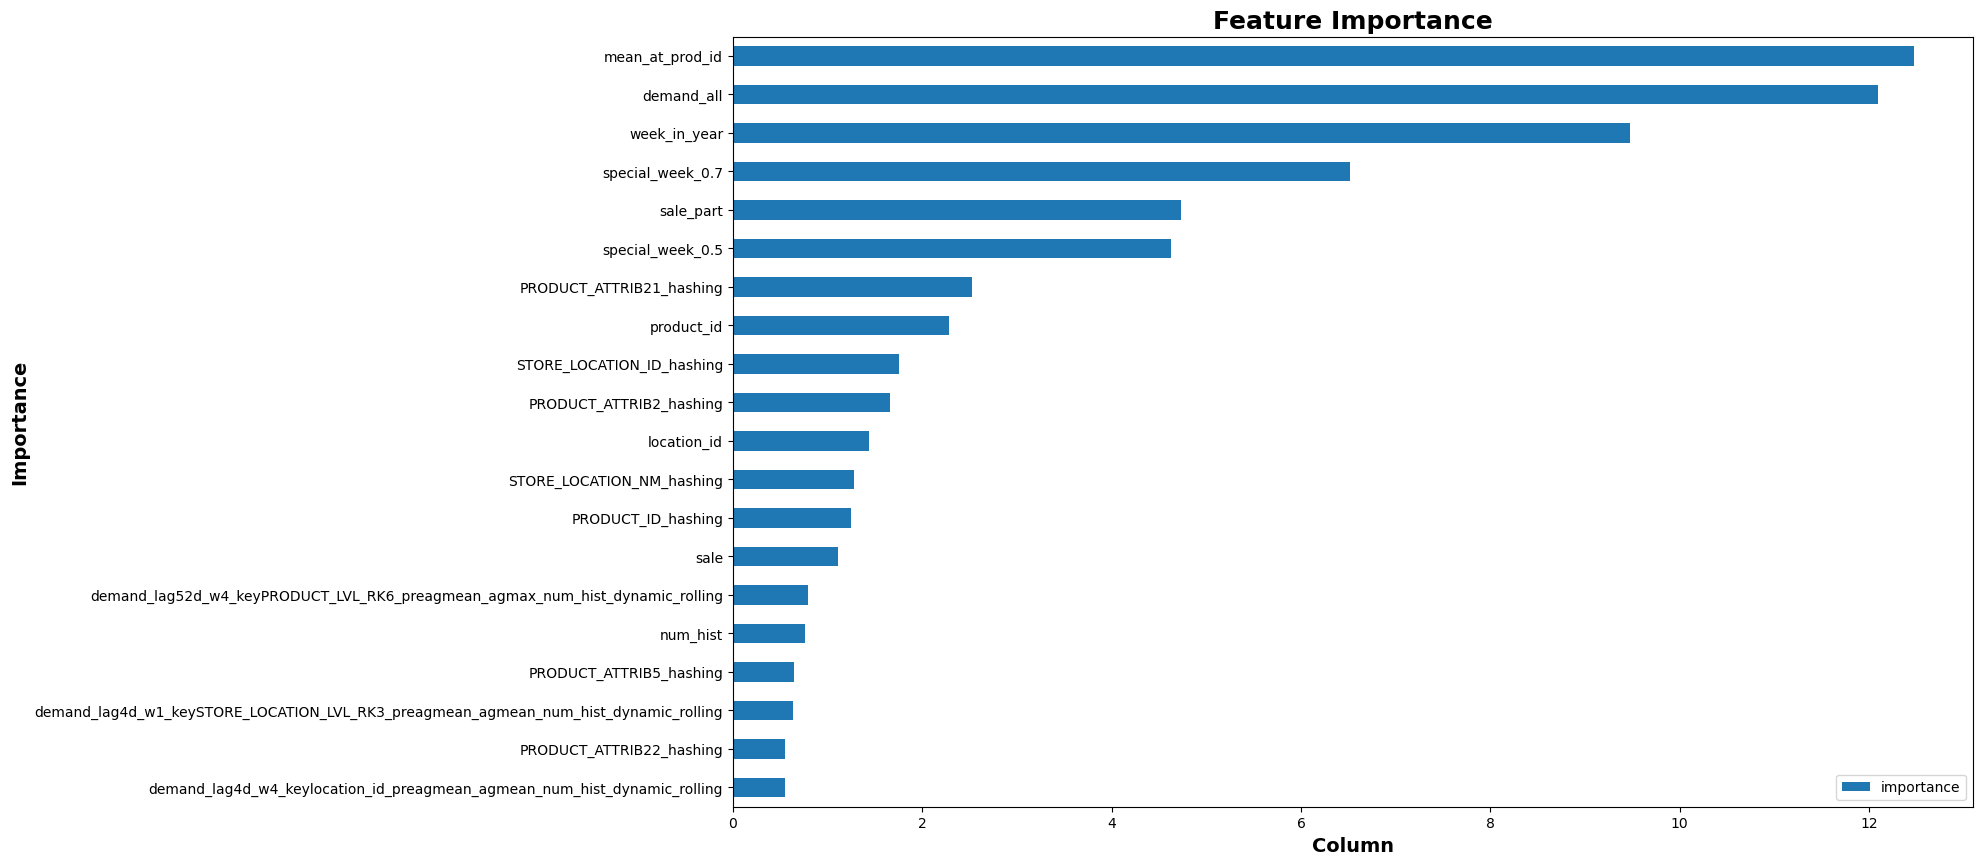

In [40]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.5000000000000002',
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
] + [
    column for column in data if column.find('hashing') != -1
]

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]

categorical_columns = list(set(categorical_columns) & set(data.columns))
bad_features = list(set(bad_features) & set(data.columns))

data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
tmp_data = tmp_data[data.num_hist != -1]
train = tmp_data[(~tmp_data.demand.isna())].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    n_estimators=700, 
    random_seed=42)

classifier.fit(train, target)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [41]:
data.to_csv("/kaggle/working/dataset_ver0.csv")


# Version 1

In [42]:
target_cols = ['demand']
id_cols = ['STORE_LOCATION_LVL_RK3', 'PRODUCT_LVL_RK6']
date_col = 'period_dt'

In [45]:
%%time
data = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [4, 8, 12, 16, 52]
                    , windows = [1, 4, 8, 12, 16, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist']
                    , ewm_params={'One': [1, 2, 8, 16, 32], 'PROMO1_FLAG' : [1, 2, 8, 16, 32], 
                                  'special_week_0.5' : [1, 2, 8, 16, 32], 'special_week_0.7' : [1, 2, 8, 16, 32],
                                  'special_week_0.9000000000000001' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_1.1' : [1, 2, 8, 16, 32], 'num_hist' : [1, 2, 8, 16, 32], 
                                  'special_week_1.3' : [1, 2, 8, 16, 32], 'special_week_0.3' : [1, 2, 8, 16, 32]}
                    , agg_methods = ['mean', 'median', 'max']
                    )

alpha: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


window and method:   0%|          | 0/18 [00:00<?, ?it/s]

window and method:   6%|▌         | 1/18 [00:01<00:29,  1.71s/it]

window and method:  11%|█         | 2/18 [00:03<00:27,  1.75s/it]

window and method:  17%|█▋        | 3/18 [00:05<00:25,  1.73s/it]

window and method:  22%|██▏       | 4/18 [00:06<00:24,  1.73s/it]

window and method:  28%|██▊       | 5/18 [00:08<00:23,  1.82s/it]

window and method:  33%|███▎      | 6/18 [00:10<00:21,  1.78s/it]

window and method:  39%|███▉      | 7/18 [00:12<00:19,  1.77s/it]

window and method:  44%|████▍     | 8/18 [00:14<00:17,  1.78s/it]

window and method:  50%|█████     | 9/18 [00:15<00:15,  1.77s/it]

window and method:  56%|█████▌    | 10/18 [00:17<00:14,  1.77s/it]

window and method:  61%|██████    | 11/18 [00:19<00:12,  1.78s/it]

window and method:  67%|██████▋   | 12/18 [00:21<00:10,  1.76s/it]

window and method:  72%|███████▏  | 13/18 [00:23<00:09,  1.82s/it]

window and 

CPU times: user 55min 24s, sys: 2min 34s, total: 57min 58s
Wall time: 57min 57s


100%|██████████| 42/42 [00:00<00:00, 119.89it/s]
/tmp/ipykernel_32/1139537807.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp_data = tmp_data[data.num_hist != -1]


Learning rate set to 0.081315
0:	learn: 0.8259985	total: 399ms	remaining: 4m 38s
1:	learn: 0.8048302	total: 731ms	remaining: 4m 15s
2:	learn: 0.7856689	total: 1.13s	remaining: 4m 22s
3:	learn: 0.7675950	total: 1.53s	remaining: 4m 26s
4:	learn: 0.7504433	total: 1.91s	remaining: 4m 26s
5:	learn: 0.7360301	total: 2.27s	remaining: 4m 22s
6:	learn: 0.7213287	total: 2.54s	remaining: 4m 11s
7:	learn: 0.7100536	total: 2.82s	remaining: 4m 4s
8:	learn: 0.6986055	total: 3.29s	remaining: 4m 12s
9:	learn: 0.6891986	total: 3.56s	remaining: 4m 5s
10:	learn: 0.6807240	total: 3.82s	remaining: 3m 59s
11:	learn: 0.6732808	total: 4.12s	remaining: 3m 56s
12:	learn: 0.6643768	total: 4.41s	remaining: 3m 52s
13:	learn: 0.6575369	total: 4.69s	remaining: 3m 50s
14:	learn: 0.6509780	total: 4.98s	remaining: 3m 47s
15:	learn: 0.6446926	total: 5.26s	remaining: 3m 44s
16:	learn: 0.6376913	total: 5.75s	remaining: 3m 51s
17:	learn: 0.6316454	total: 6.1s	remaining: 3m 51s
18:	learn: 0.6263954	total: 6.38s	remaining: 3m

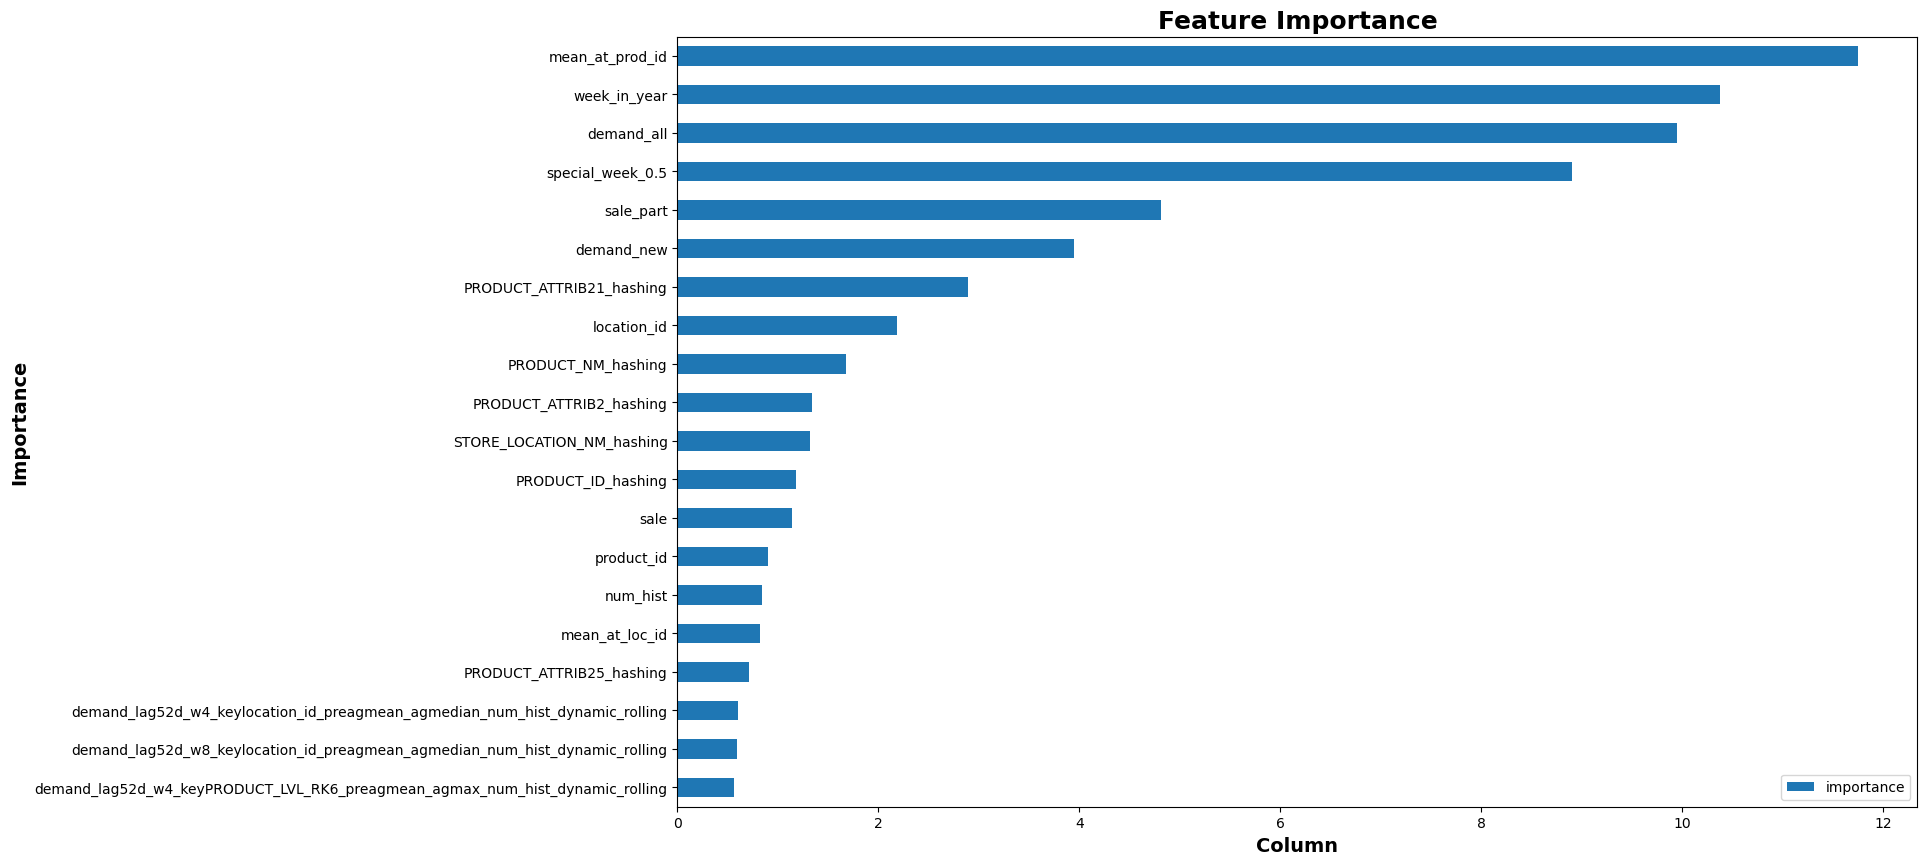

In [46]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.5000000000000002',
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
] + [
    column for column in data if column.find('hashing') != -1
]

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]

categorical_columns = list(set(categorical_columns) & set(data.columns))
bad_features = list(set(bad_features) & set(data.columns))

data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
tmp_data = tmp_data[data.num_hist != -1]
train = tmp_data[(~tmp_data.demand.isna())].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    n_estimators=700, 
    random_seed=42)

classifier.fit(train, target)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [48]:
len(data.columns)

476

In [1]:
target_cols = ['demand']
id_cols = ['location_id', 'PRODUCT_LVL_RK6']
date_col = 'period_dt'

In [ ]:
%%time
data = generate_lagged_features(data
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [4, 8, 12, 16, 52]
                    , windows = [1, 4, 8, 12, 16, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist', 'year_num']
                    , ewm_params={'One': [1, 2, 8, 16, 32], 'PROMO1_FLAG' : [1, 2, 8, 16, 32], 
                                  'special_week_0.5' : [1, 2, 8, 16, 32], 'special_week_0.7' : [1, 2, 8, 16, 32],
                                  'special_week_0.9000000000000001' : [1, 2, 4, 8, 16, 32], 
                                  'special_week_1.1' : [1, 2, 8, 16, 32], 'num_hist' : [1, 2, 8, 16, 32], 
                                  'year_num' : [1, 2, 8, 16, 32], 'special_week_1.3' : [1, 2, 8, 16, 32], 'special_week_0.3' : [1, 2, 8, 16, 32]}
                    , agg_methods = ['mean', 'median', 'max']
                    )

alpha: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


window and method:   0%|          | 0/18 [00:00<?, ?it/s]

window and method:   6%|▌         | 1/18 [00:02<00:48,  2.87s/it]

window and method:  11%|█         | 2/18 [00:05<00:45,  2.87s/it]

window and method:  17%|█▋        | 3/18 [00:08<00:42,  2.83s/it]

window and method:  22%|██▏       | 4/18 [00:11<00:39,  2.85s/it]

window and method:  28%|██▊       | 5/18 [00:14<00:37,  2.85s/it]

window and method:  33%|███▎      | 6/18 [00:17<00:33,  2.83s/it]

window and method:  39%|███▉      | 7/18 [00:19<00:31,  2.85s/it]

window and method:  44%|████▍     | 8/18 [00:22<00:28,  2.87s/it]

window and method:  50%|█████     | 9/18 [00:25<00:25,  2.86s/it]

window and method:  56%|█████▌    | 10/18 [00:28<00:22,  2.86s/it]

window and method:  61%|██████    | 11/18 [00:31<00:20,  2.86s/it]

window and method:  67%|██████▋   | 12/18 [00:34<00:17,  2.85s/it]

window and method:  72%|███████▏  | 13/18 [00:36<00:14,  2.81s/it]

window and 

In [ ]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'PROMO2_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.5000000000000002',
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
] + [
    column for column in data if column.find('hashing') != -1
]

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]

categorical_columns = list(set(categorical_columns) & set(data.columns))
bad_features = list(set(bad_features) & set(data.columns))

data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
tmp_data = tmp_data[data.num_hist != -1]
train = tmp_data[(~tmp_data.demand.isna())].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    n_estimators=700, 
    random_seed=42)

classifier.fit(train, target)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [ ]:
data.to_csv("/kaggle/working/dataset_ver1.csv")


# Version 1.5

In [ ]:
target_cols = ['demand']
id_cols = ['PRODUCT_LVL_RK6']
date_col = 'period_dt'

In [ ]:
%%time
data_lagged = data
prev_cols = []
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2]
                    , windows = [1, 4, 12, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist', 'year_num']
                    , ewm_params={'One': [1, 4, 14], 'PROMO1_FLAG' : [1, 4, 14], 
                                  'special_week_0.5' : [1, 4, 14], 'special_week_0.7' : [1, 4, 14],
                                  'special_week_0.9000000000000001' : [1, 4, 14], 
                                  'special_week_1.1' : [1, 4, 14], 'num_hist' : [1, 4, 14], 
                                  'year_num' : [1, 4, 14], 'special_week_1.3' : [1, 4, 14], 'special_week_0.3' : [1, 4, 14]}
                    , agg_methods = ['mean', 'median', 'max']
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
]+ [
    column for column in data if column.find('hashing') != -1
]

# фильтруем столбики

def get_large_nunique_columns(df, subset_columns=None, nunique_trhld = 100):
    res = []
    columns = subset_columns
    if subset_columns is None:
        columns = df.columns
    for column in tqdm(columns):
        if df[column].nunique() > nunique_trhld:
            res.append(column)
    return res

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]
data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
valid = tmp_data[tmp_data.index.isin(validation_ids)]
valid_target = valid['demand']
valid = valid.drop(columns=['demand'])
train = tmp_data[(~tmp_data.demand.isna()) & (~tmp_data.index.isin(valid.index))
            ].drop(columns=['demand'])
test = tmp_data.loc[vanila_test.id, :].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

lims = [0.0, 0.8, 1.2, 1.5, 1.9, 2.1, 2.8, np.inf]

def make_classes(lims, target):
    target_classify = target.copy()
    target_classify.iloc[:] = 1
    
    for i in range(len(lims)-1):
        l, r = lims[i], lims[i+1]
        mask = (target >= l) & (target < r)
        value = target[mask].quantile(0.5)
        target_classify[mask] = value
    
    return target_classify

target_classify = make_classes(lims, target)
valid_class = make_classes(lims, valid_target)

class_weights = {
    value: 1 if value <= 1 else 10
    for value in target_classify
}

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    #eval_metric='Accuracy', 
    n_estimators=700, 
    #class_weights=class_weights,
    random_seed=42)

classifier.fit(train, target_classify)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [ ]:
target_cols = ['demand']
id_cols = ['location_id']
date_col = 'period_dt'

In [ ]:
%%time
data_lagged = data
prev_cols = []
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2]
                    , windows = [1, 4, 12, 52]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week_0.3', 'special_week_0.5', 'special_week_0.7', 
                                        'special_week_0.9000000000000001', 'special_week_1.1', 
                                        'special_week_1.3', 'num_hist', 'year_num']
                    , ewm_params={'One': [1, 4, 14], 'PROMO1_FLAG' : [1, 4, 14], 
                                  'special_week_0.5' : [1, 4, 14], 'special_week_0.7' : [1, 4, 14],
                                  'special_week_0.9000000000000001' : [1, 4, 14], 
                                  'special_week_1.1' : [1, 4, 14], 'num_hist' : [1, 4, 14], 
                                  'year_num' : [1, 4, 14], 'special_week_1.3' : [1, 4, 14], 'special_week_0.3' : [1, 4, 14]}
                    , agg_methods = ['mean', 'median', 'max']
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
categorical_columns = [
    'location_id',
    'product_id',
    'PROMO1_FLAG',
    'AUTORIZATION_FLAG',
    'special_week_0.3', 
    'special_week_0.5', 
    'special_week_0.7', 
    'special_week_0.9000000000000001', 
    'special_week_1.1', 
    'special_week_1.3',
    'STORE_LOCATION_LVL_RK4',
    'STORE_LOCATION_LVL_RK3',
    'week_in_year',
    'PRODUCT_LVL_RK6',
]+ [
    column for column in data if column.find('hashing') != -1
]

# фильтруем столбики

def get_large_nunique_columns(df, subset_columns=None, nunique_trhld = 100):
    res = []
    columns = subset_columns
    if subset_columns is None:
        columns = df.columns
    for column in tqdm(columns):
        if df[column].nunique() > nunique_trhld:
            res.append(column)
    return res

bad_features = [
    'period_dt',
    'id',
    'year_num',
    'week_num',
    'VALID_FROM_DTTM_product'
]
data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
valid = tmp_data[tmp_data.index.isin(validation_ids)]
valid_target = valid['demand']
valid = valid.drop(columns=['demand'])
train = tmp_data[(~tmp_data.demand.isna()) & (~tmp_data.index.isin(valid.index))
            ].drop(columns=['demand'])
test = tmp_data.loc[vanila_test.id, :].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

lims = [0.0, 0.8, 1.2, 1.5, 1.9, 2.1, 2.8, np.inf]

def make_classes(lims, target):
    target_classify = target.copy()
    target_classify.iloc[:] = 1
    
    for i in range(len(lims)-1):
        l, r = lims[i], lims[i+1]
        mask = (target >= l) & (target < r)
        value = target[mask].quantile(0.5)
        target_classify[mask] = value
    
    return target_classify

target_classify = make_classes(lims, target)
valid_class = make_classes(lims, valid_target)

class_weights = {
    value: 1 if value <= 1 else 10
    for value in target_classify
}

classifier = CatBoostRegressor(
    cat_features=categorical_columns,
    #eval_metric='Accuracy', 
    n_estimators=700, 
    #class_weights=class_weights,
    random_seed=42)

classifier.fit(train, target_classify)

fi = pd.DataFrame({'column': train.columns, 'importance': classifier.feature_importances_})
fi.sort_values('importance', ascending=True).tail(20).set_index('column').plot.barh(figsize=(16, 10))
plt.ylabel('Importance', weight='bold', size=14)
plt.xlabel('Column', weight='bold', size=14)
plt.title('Feature Importance', weight='bold', size=18)
plt.show()

data = data.drop(columns = fi.loc[(fi['importance'] < 0.01) & (~fi['column'].isin(important_columns)), 'column'].to_numpy())

data['period_dt'] = pd.to_datetime(data["period_dt"])
data['One'] = 1

In [ ]:
data.to_csv("/kaggle/working/dataset_ver1_5.csv")


In [ ]:

data.index = data.id
tmp_data = data[data.week_in_year.isin(data[data.id.isin(vanila_test.id)].week_in_year.unique())].drop(columns=bad_features)
tmp_data = tmp_data[tmp_data.num_hist != -1]
categorical_columns = list(set(categorical_columns) - set(bad_features))
for column in tqdm(categorical_columns):
    tmp_data[column] = tmp_data[column].fillna('NaN').astype(str)
    
valid = tmp_data[tmp_data.index.isin(validation_ids)]
valid_target = valid['demand']
valid = valid.drop(columns=['demand'])
train = tmp_data[(~tmp_data.demand.isna()) & (~tmp_data.index.isin(valid.index))
            ].drop(columns=['demand'])
test = tmp_data.loc[vanila_test.id, :].drop(columns=['demand'])
target = tmp_data.loc[train.index, 'demand']

lims = [0.0, 0.95, 1.05, 1.5, 1.9, 2.1, 2.8, np.inf]

def make_classes(lims, target):
    target_classify = target.copy()
    target_classify.iloc[:] = 1
    
    for i in range(len(lims)-1):
        l, r = lims[i], lims[i+1]
        mask = (target >= l) & (target < r)
        value = target[mask].quantile(0.5)
        target_classify[mask] = value
    
    return target_classify

target_classify = make_classes(lims, target)
valid_class = make_classes(lims, valid_target)

class_weights = {
    value: 1 if value <= 1 else 10
    for value in target_classify
}

classifier = CatBoostClassifier(
    cat_features=categorical_columns,
    eval_metric='Accuracy', 
    n_estimators=700, 
    class_weights=class_weights,
    random_seed=42)

In [ ]:

classifier.fit(train, target_classify)

In [ ]:
valid_pred = classifier.predict(valid).reshape(-1)
valid_proba = pd.DataFrame(classifier.predict_proba(valid), columns=classifier.classes_)

valid_pred[valid_proba[3.666667] > 0.7] = 1.1
valid_pred[valid_proba[3.666667] <= 0.7] = 1

# Version 3

In [ ]:
data = pd.read_csv("/kaggle/input/dataframe/dataset_ver2.csv")
data['period_dt'] = pd.to_datetime(data["period_dt"])
data.drop(columns=[data.columns[0]], inplace=True)

In [ ]:
target_cols = ['demand']
id_cols = ['location_id']
date_col = 'period_dt'
prev_cols = data.columns

In [ ]:
%%time
data_lagged = data
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2, 3]
                    , windows = [2, 3]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week']
                    , ewm_params={'One': [2, 3], 'PROMO1_FLAG': [2, 3], 'special_week' : [2, 3]}
                    , agg_methods = ['mean', 'median', percentile(10),]
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
data.to_csv("/kaggle/working/dataset_ver3.csv")


# Version 4

In [ ]:
target_cols = ['demand']
id_cols = ['product_id']
date_col = 'period_dt'
prev_cols = data.columns

In [ ]:
%%time
data_lagged = data
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2, 3]
                    , windows = [2, 3]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week']
                    , ewm_params={'One': [2, 3], 'PROMO1_FLAG': [2, 3], 'special_week' : [2, 3]}
                    , agg_methods = ['mean', 'median', percentile(10),]
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
data.to_csv("/kaggle/working/dataset_ver4.csv")

# Version 5

In [ ]:
target_cols = ['demand']
id_cols = ['STORE_LOCATION_LVL_RK4']
date_col = 'period_dt'
prev_cols = data.columns

In [ ]:
%%time
data_lagged = data
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2, 3]
                    , windows = [2, 3]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week']
                    , ewm_params={'One': [2, 3], 'PROMO1_FLAG': [2, 3], 'special_week' : [2, 3]}
                    , agg_methods = ['mean', 'median', percentile(10),]
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
target_cols = ['demand']
id_cols = ['STORE_LOCATION_LVL_RK3']
date_col = 'period_dt'
prev_cols = data.columns

In [ ]:
%%time
data_lagged = data
for i in range(2):
    data_lagged = generate_lagged_features(data_lagged
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [2, 3]
                    , windows = [2, 3]
                    , preagg_methods = ['mean']
                    , dynamic_filters = ['One', 'PROMO1_FLAG', 'special_week']
                    , ewm_params={'One': [2, 3], 'PROMO1_FLAG': [2, 3], 'special_week' : [2, 3]}
                    , agg_methods = ['mean', 'median', percentile(10),]
                    )
    target_cols = data_lagged.columns.difference(prev_cols).to_numpy()
    prev_cols = data_lagged.columns
data = data_lagged

In [ ]:
data.to_csv("/kaggle/working/dataset_ver5.csv")